<h1>Example: Attention-based Deep Multiple Instance Learning</h1>

In [1]:
# Import general modules used for e.g. plotting.
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import torch

# Import Hopfield-specific modules.
from modules import HopfieldPooling

# Import auxiliary modules.
from distutils.version import LooseVersion
from typing import Optional, Tuple

# Importing PyTorch specific modules.
from torch import Tensor
from torch.autograd import Variable
from torch.nn import Conv2d, Dropout, Linear, MaxPool2d, Module, ReLU, Sequential, Sigmoid
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset

# Set plotting style.
sns.set()

Append the path of the Attention-based Deep Multiple Instance Learning (ADMIL) repository to the system path in order for Python to find the corresponding modules to import.

In [2]:
sys.path.append(r'./AttentionDeepMIL')

Afterwards, the corresponding modules
- <code>MnistBags</code>
- <code>Attention</code>
- <code>GatedAttention</code>

are imported to the global namespace.

In [3]:
from dataloader import MnistBags
from model import Attention, GatedAttention

Specific minimum versions of Python itself as well as of some used modules is required.

In [4]:
python_check = '(\u2713)' if sys.version_info >= (3, 8) else '(\u2717)'
pytorch_check = '(\u2713)' if torch.__version__ >= LooseVersion(r'1.5') else '(\u2717)'

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro} {python_check}')
print(f'Installed PyTorch version: {torch.__version__} {pytorch_check}')

Installed Python version:  3.8.11 (✓)
Installed PyTorch version: 1.7.0 (✓)


<h3 style="color:rgb(0,120,170)">Create Dataset</h3>

The dataset itself falls into the category of <i>binary classification</i> tasks in the domain of <i>Multiple Instance Learning (MIL)</i> problems.
The MNIST-bags task was introcuded by Ilse and Tomczak:<br>
<cite>Ilse, M., Tomczak, J.M. and Welling, M., 2018. Attention-based deep multiple instance learning. arXiv preprint arXiv:1802.04712.</cite><br><br>
Each bag comprises a collection of $28\times{}28$ grayscale images/instances, whereas each instance is a sequence of pixel values in the range of $[0; 255]$. The amount of instances per pag is drawn from a Gaussian with specified mean and variance. The positive class is defined by the presence of the target number/digit, whereas the negative one by its absence. This demonstration shows, that <code>HopfieldPooling</code> is capable of learning and filtering each bag with respect to the class-defining target number/digit. Defining arguments are:
<br><br>
<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this demo)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>target_number</code></th>
        <th>9</th>
        <th>Target number/digit defining class affiliation.</th>
    </tr>
    <tr>
        <th><code>mean_bag_length</code></th>
        <th>10</th>
        <th>Mean amount of instances per bag.</th>
    </tr>
    <tr>
        <th><code>var_bag_length</code></th>
        <th>2</th>
        <th>Variance of amount of instances per bag.</th>
    </tr>
    <tr>
        <th><code>num_bag</code></th>
        <th>{200; 50}</th>
        <th>Amount of samples of the training as well as validation set.</th>
    </tr>
</table>

Let's define the dataset using previously mentioned properties as well as a logging directory for storing all auxiliary outputs like performance plots.

In [8]:
device = torch.device(r'cuda:0' if torch.cuda.is_available() else r'cpu')

train_dataset = MnistBags(
    target_number=9,
    mean_bag_length=10,
    var_bag_length=2,
    num_bag=200,
    train=True)

# Create data loader of training set.
data_loader_train = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Create data loader of validation set.
data_loader_eval = DataLoader(MnistBags(
    target_number=9,
    mean_bag_length=10,
    var_bag_length=2,
    num_bag=50,
    train=False
), batch_size=1, shuffle=True)

In [6]:
log_dir = f'resources/'
os.makedirs(log_dir, exist_ok=True)

<h3 style="color:rgb(0,120,170)">Visualize the data</h3>

In [67]:
def print_sample_metadata(idx: int, dataset: Dataset):
    """print one example metadata"""
    X, y = dataset[idx]
    print("#" * 15, f" Sample idx: {idx}", "#" * 15)
    print(f"Shape of input: {X.shape}")
    print(f"Output: {y}")

In [69]:
samples = np.random.randint(0, len(train_dataset), size=5)
for sample in samples:
    print_sample_metadata(sample, train_dataset)

###############  Sample idx: 76 ###############
Shape of input: torch.Size([9, 1, 28, 28])
Output: [tensor(False), tensor([False, False, False, False, False, False, False, False, False])]
###############  Sample idx: 59 ###############
Shape of input: torch.Size([11, 1, 28, 28])
Output: [tensor(True), tensor([False, False, False,  True,  True, False,  True, False, False, False,
        False])]
###############  Sample idx: 77 ###############
Shape of input: torch.Size([9, 1, 28, 28])
Output: [tensor(False), tensor([False, False, False, False, False, False, False, False, False])]
###############  Sample idx: 107 ###############
Shape of input: torch.Size([10, 1, 28, 28])
Output: [tensor(True), tensor([False, False, False, False, False, False, False, False,  True, False])]
###############  Sample idx: 4 ###############
Shape of input: torch.Size([9, 1, 28, 28])
Output: [tensor(False), tensor([False, False, False, False, False, False, False, False, False])]


In [74]:
import matplotlib.pyplot as plt

def plot_bags(target, bags, dataset):
    fig, axs = plt.subplots(len(bags), 1, figsize=(12, 12))
    axs = axs.flatten()

    for idx, ax in zip(bags, axs):
        X, y = dataset[idx]
        X = X.cpu().numpy()
        X = np.concatenate(X, axis=2)

        label, location = y
        label = label.item()
        location = location.cpu().numpy()
        location = np.argwhere(location == True)
        location = np.squeeze(location)
        ax.imshow(np.squeeze(X, axis=0), cmap='gray')
        if label:
            ax.set_title(f'There is a {target} in this bag at pos {location}')
        else:
            ax.set_title(f'There is no {target} in this bag')
        ax.grid(False)

    plt.show()

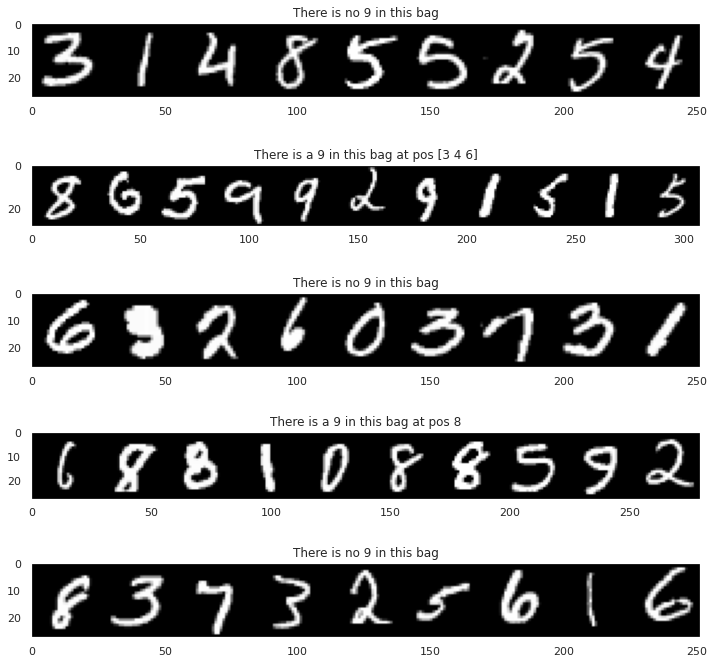

In [75]:
plot_bags(9, samples, train_dataset)

<h3 style="color:rgb(0,120,170)">Create Auxiliaries</h3>

Before digging into Hopfield-based networks, a few auxiliary variables and functions need to be defined. This is nothing special with respect to Hopfield-based networks, but rather common preparation work of (almost) every machine learning setting (e.g. definition of a <i>data loader</i> as well as a <i>training loop</i>). We will see, that this comprises the most work of this whole demo.

In [7]:
def train_epoch(network: Module,
                optimiser: AdamW,
                data_loader: DataLoader
               ) -> Tuple[float, float, float]:
    """
    Execute one training epoch.
    
    :param network: network instance to train
    :param optimiser: optimiser instance responsible for updating network parameters
    :param data_loader: data loader instance providing training data
    :return: tuple comprising training loss, training error as well as accuracy
    """
    network.train()
    losses, errors, accuracies = [], [], []
    for data, target in data_loader:
        data, target = data.to(device=device), target[0].to(device=device)

        # Process data by Hopfield-based network.
        loss = network.calculate_objective(data, target)[0]

        # Update network parameters.
        optimiser.zero_grad()
        loss.backward()
        clip_grad_norm_(parameters=network.parameters(), max_norm=1.0, norm_type=2)
        optimiser.step()

        # Compute performance measures of current model.
        error, prediction = network.calculate_classification_error(data, target)
        accuracy = (prediction == target).to(dtype=torch.float32).mean()
        accuracies.append(accuracy.detach().item())
        errors.append(error)
        losses.append(loss.detach().item())
    
    # Report progress of training procedure.
    return sum(losses) / len(losses), sum(errors) / len(errors), sum(accuracies) / len(accuracies)


def eval_iter(network: Module,
              data_loader: DataLoader
             ) -> Tuple[float, float, float]:
    """
    Evaluate the current model.
    
    :param network: network instance to evaluate
    :param data_loader: data loader instance providing validation data
    :return: tuple comprising validation loss, validation error as well as accuracy
    """
    network.eval()
    with torch.no_grad():
        losses, errors, accuracies = [], [], []
        for data, target in data_loader:
            data, target = data.to(device=device), target[0].to(device=device)

            # Process data by Hopfield-based network.
            loss = network.calculate_objective(data, target)[0]

            # Compute performance measures of current model.
            error, prediction = network.calculate_classification_error(data, target)
            accuracy = (prediction == target).to(dtype=torch.float32).mean()
            accuracies.append(accuracy.detach().item())
            errors.append(error)
            losses.append(loss.detach().item())

        # Report progress of validation procedure.
        return sum(losses) / len(losses), sum(errors) / len(errors), sum(accuracies) / len(accuracies)

    
def operate(network: Module,
            optimiser: AdamW,
            data_loader_train: DataLoader,
            data_loader_eval: DataLoader,
            num_epochs: int = 1
           ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Train the specified network by gradient descent using backpropagation.
    
    :param network: network instance to train
    :param optimiser: optimiser instance responsible for updating network parameters
    :param data_loader_train: data loader instance providing training data
    :param data_loader_eval: data loader instance providing validation data
    :param num_epochs: amount of epochs to train
    :return: data frame comprising training as well as evaluation performance
    """
    losses, errors, accuracies = {r'train': [], r'eval': []}, {r'train': [], r'eval': []}, {r'train': [], r'eval': []}
    for epoch in range(num_epochs):
        
        # Train network.
        performance = train_epoch(network, optimiser, data_loader_train)
        losses[r'train'].append(performance[0])
        errors[r'train'].append(performance[1])
        accuracies[r'train'].append(performance[2])
        
        # Evaluate current model.
        performance = eval_iter(network, data_loader_eval)
        losses[r'eval'].append(performance[0])
        errors[r'eval'].append(performance[1])
        accuracies[r'eval'].append(performance[2])
    
    # Report progress of training and validation procedures.
    return pd.DataFrame(losses), pd.DataFrame(errors), pd.DataFrame(accuracies)

In [8]:
def set_seed(seed: int = 42) -> None:
    """
    Set seed for all underlying (pseudo) random number sources.
    
    :param seed: seed to be used
    :return: None
    """
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def plot_performance(loss: pd.DataFrame,
                     error: pd.DataFrame,
                     accuracy: pd.DataFrame,
                     log_file: str
                    ) -> None:
    """
    Plot and save loss and accuracy.
    
    :param loss: loss to be plotted
    :param error: error to be plotted
    :param accuracy: accuracy to be plotted
    :param log_file: target file for storing the resulting plot
    :return: None
    """
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    
    loss_plot = sns.lineplot(data=loss, ax=ax[0])
    loss_plot.set(xlabel=r'Epoch', ylabel=r'Loss')
    
    error_plot = sns.lineplot(data=error, ax=ax[1])
    error_plot.set(xlabel=r'Epoch', ylabel=r'Error')
    
    accuracy_plot = sns.lineplot(data=accuracy, ax=ax[2])
    accuracy_plot.set(xlabel=r'Epoch', ylabel=r'Accuracy')
    
    fig.tight_layout()
    fig.savefig(log_file)
    plt.show(fig)

<h1>Attention-based Network</h1>

In [9]:
set_seed()
network = Attention().to(device=device)
optimiser = AdamW(params=network.parameters(), lr=5e-4, weight_decay=1e-4)

<h3 style="color:rgb(0,120,170)">Operate Attention-based Network</h3>

In [10]:
losses, errors, accuracies = operate(
    network=network,
    optimiser=optimiser,
    data_loader_train=data_loader_train,
    data_loader_eval=data_loader_eval,
    num_epochs=20)

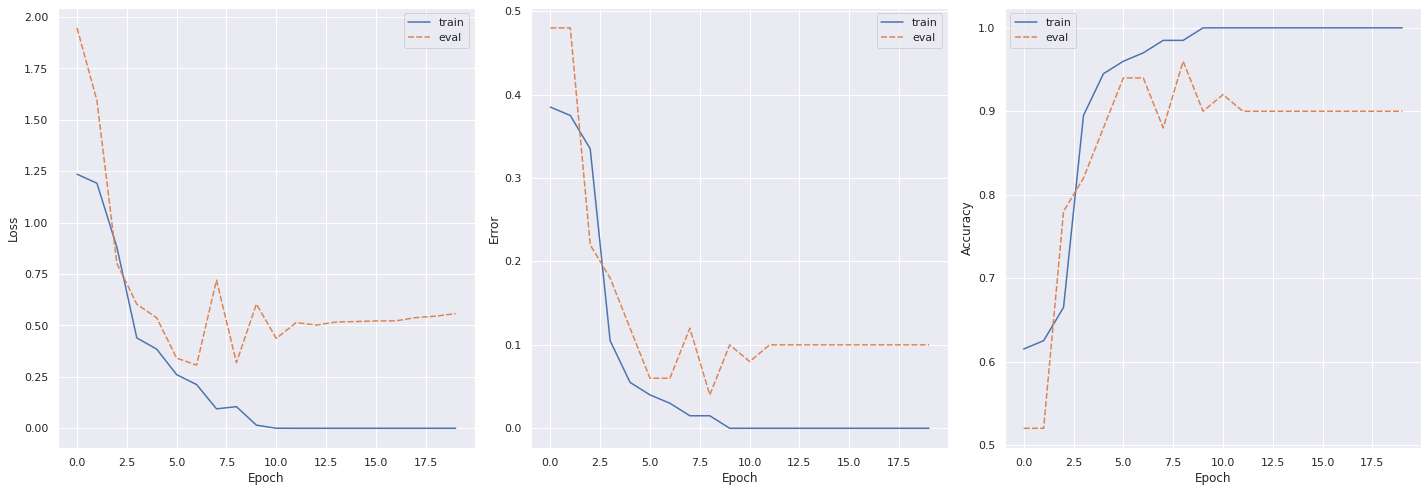

In [12]:
plot_performance(loss=losses, error=errors, accuracy=accuracies, log_file=f'{log_dir}/attention_base.pdf')

<h1>GatedAttention-based Network</h1>

In [13]:
set_seed()
network = GatedAttention().to(device=device)
optimiser = AdamW(params=network.parameters(), lr=5e-4, weight_decay=1e-4)

<h3 style="color:rgb(0,120,170)">Operate GatedAttention-based Network</h3>

In [14]:
losses, errors, accuracies = operate(
    network=network,
    optimiser=optimiser,
    data_loader_train=data_loader_train,
    data_loader_eval=data_loader_eval,
    num_epochs=20)

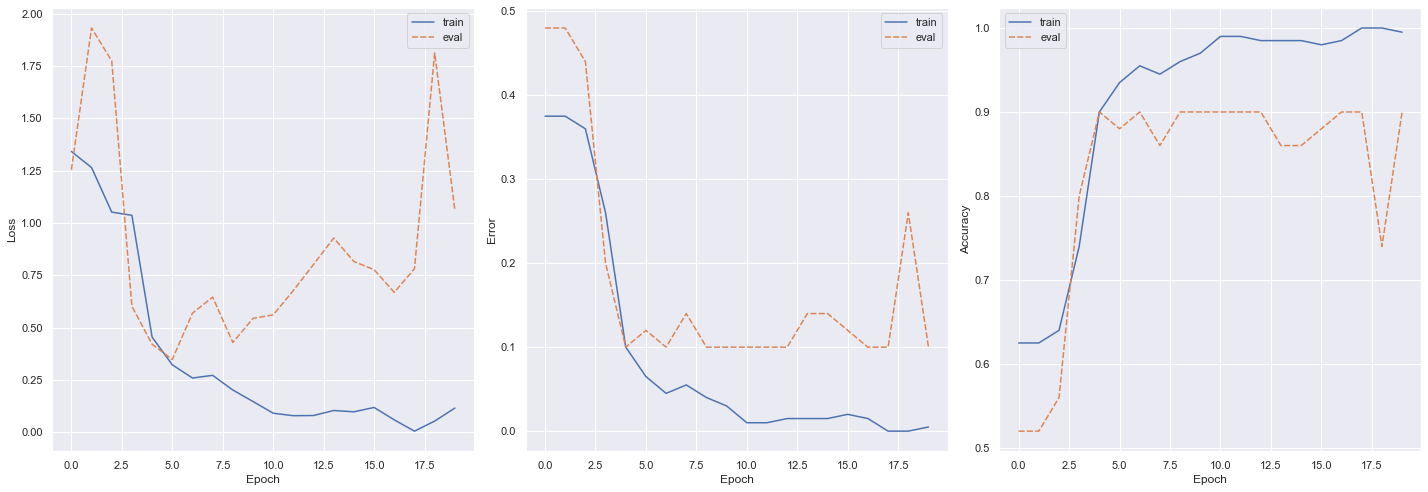

In [14]:
plot_performance(loss=losses, error=errors, accuracy=accuracies, log_file=f'{log_dir}/gated_attention_base.pdf')

<h1>Hopfield-based Pooling</h1>

In [15]:
class HfPooling(Module):    
    def __init__(self):
        """
        Initialize a new instance of a Hopfield-based pooling network.
        
        Note: all hyperparameters of the network are fixed for demonstration purposes.
        Morevover, most of the notation of the original implementation is kept in order
        to be easier comparable (partially ignoring PEP8).
        """
        super(HfPooling, self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1

        self.feature_extractor_part1 = Sequential(
            Conv2d(1, 20, kernel_size=5),
            ReLU(),
            MaxPool2d(2, stride=2),
            Conv2d(20, 50, kernel_size=5),
            ReLU(),
            MaxPool2d(2, stride=2)
        )
        self.feature_extractor_part2 = Sequential(
            Linear(50 * 4 * 4, self.L),
            ReLU(),
        )
        self.hopfield_pooling = HopfieldPooling(
            input_size=self.L, hidden_size=32, output_size=self.L, num_heads=1
        )
        self.dp = Dropout(
            p=0.1
        )
        self.classifier = Sequential(
            Linear(self.L * self.K, 1),
            Sigmoid()
        )
        
    def forward(self, input: Tensor) -> Tuple[Tensor, Tensor, Optional[Tensor]]:
        """
        Compute result of Hopfield-based pooling network on specified data.
        
        :param input: data to be processed by the Hopfield-based pooling network
        :return: result as computed by the Hopfield-based pooling network
        """
        x = input.squeeze(0)
        H = self.feature_extractor_part1(x)
        H = H.view(-1, 50 * 4 * 4)
        H = self.feature_extractor_part2(H)
        
        H = H.unsqueeze(0)
        H = self.hopfield_pooling(H)
        H = H.squeeze(0)
        H = self.dp(H)

        Y_prob = self.classifier(H)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, None

    def calculate_classification_error(self, input: Tensor, target: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Compute classification error of current model.
        
        :param input: data to be processed by the Hopfield-based pooling network
        :param target: target to be used to compute the classification error of the current model
        :return: classification error as well as predicted class
        """
        Y = target.float()
        _, Y_hat, _ = self.forward(input)
        error = 1.0 - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, input: Tensor, target: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
        """
        Compute objective of the current model.
        
        :param input: data to be processed by the Hopfield-based pooling network
        :param target: target to be used to compute the objective of the current model
        :return: objective as well as dummy A (see accompanying paper for more information)
        """
        Y = target.float()
        Y_prob, _, A = self.forward(input)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=(1.0 - 1e-5))
        neg_log_likelihood = -1.0 * (Y * torch.log(Y_prob) + (1.0 - Y) * torch.log(1.0 - Y_prob))

        return neg_log_likelihood, A

In [16]:
set_seed()
network = HfPooling().to(device=device)
optimiser = AdamW(params=network.parameters(), lr=5e-4, weight_decay=1e-4)

<h3 style="color:rgb(0,120,170)">Operate HopfieldPooling-based Network</h3>

In [17]:
losses, errors, accuracies = operate(
    network=network,
    optimiser=optimiser,
    data_loader_train=data_loader_train,
    data_loader_eval=data_loader_eval,
    num_epochs=20)

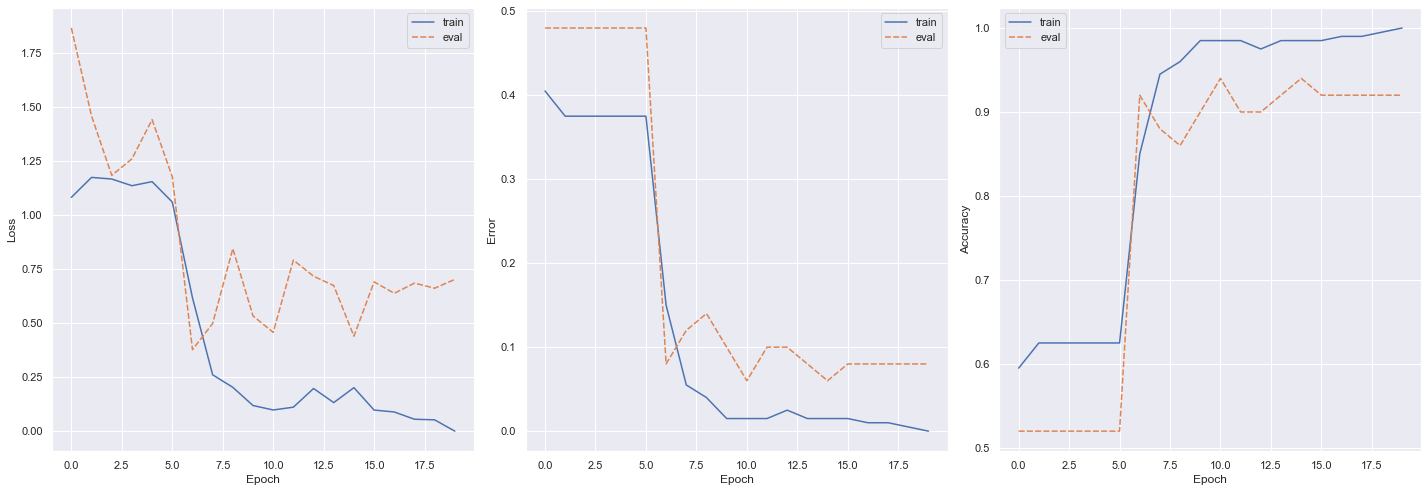

In [18]:
plot_performance(loss=losses, error=errors, accuracy=accuracies, log_file=f'{log_dir}/hopfield_pooling.pdf')